### Download data

We will download data from NYU box and extract it to local disk. It may take a couple of minutes

In [ ]:
! wget -O weather.zip "https://nyu.box.com/shared/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip"

In [1]:
str_path = "./weather/"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from sklearn import linear_model

np.random.seed(2021)

In [3]:
def extract_temp(file_name,col_ind):
    data_aux = np.loadtxt(file_name, usecols=range(10))
    data = data_aux[:,col_ind]
    err_count = 0
    ind_errs = []
    for ind in range(data.shape[0]):
        if data[ind] > 100 or data[ind] < -100:
            err_count = err_count + 1
            ind_errs.append(ind)
            data[ind] = data[ind-1]  
    print("File name: " + file_name)
    print("Errors: " + str(err_count) + " Indices: " + str(ind_errs))
    return data

def create_data_matrix(str_path):
    file_name_list = listdir(str_path)
    file_name_list.sort()
    col_ind = 8 # 8 = last 5 minutes, 9 = average over the whole hour
    data_matrix = []
    ind = 0
    for file_name in file_name_list:
        if file_name[0] == '.':
            continue
        else:
            print("Station " + str(ind))
            ind = ind + 1
            data_aux = extract_temp(str_path + file_name,col_ind)
            if len(data_matrix) == 0:
                data_matrix = data_aux
            else:
                data_matrix = np.vstack((data_matrix,data_aux))
    return data_matrix.T

In [4]:
load_files = False
if load_files:
    str_path_2015 = str_path + "hourly/2015/"
    data_matrix = create_data_matrix(str_path_2015)
else:
    data_matrix = np.load(str_path +"hourly_temperature_2015.npy")

file_name_list = listdir(str_path + "hourly/2015/")
file_name_list.sort()

### prepare data for training

In [5]:
ind_response = 18
print("Response is " + str(file_name_list[ind_response]))
y_raw = data_matrix[:,ind_response]
ind_X = np.hstack((np.arange(0,ind_response),np.arange(ind_response+1,data_matrix.shape[1])))
X_raw = data_matrix[:,ind_X]
n_features = X_raw.shape[1]

Response is CRNH0203-2015-AL_Valley_Head_1_SSW.txt


In [6]:
n_test = int(1e3)
n_val = int(1e2)
n_train = data_matrix.shape[0] - n_test - n_val

In [7]:
aux_ind = np.random.permutation(range(data_matrix.shape[0]))
ind_test = aux_ind[:n_test]
ind_val = aux_ind[n_test:(n_test+n_val)]
X_test = X_raw[ind_test,:]
y_test = y_raw[ind_test]
X_val = X_raw[ind_val,:]
y_val = y_raw[ind_val]
ind_train = aux_ind[(n_test+n_val):int(n_test+n_val+n_train)]
X_train = X_raw[ind_train,:]
y_train = y_raw[ind_train]

For this problem we will work with features that are zero mean and unit variance. We standardize the data below. Make sure to standardize the validation and test data using the statistics you compute from train data

In [8]:
center_vec = X_train.mean(axis=0)
X_train_centered = X_train - center_vec
col_norms = np.linalg.norm(X_train_centered, axis=0) / np.sqrt(n_train)
X_train_norm = np.true_divide(X_train_centered, col_norms)

y_train_center = y_train.mean()
y_train_centered = y_train - y_train_center
norm_y_train = np.linalg.norm(y_train_centered) / np.sqrt(n_train)
y_train_norm = y_train_centered / norm_y_train

#### 4(c)

In [9]:
X_test_centered = X_test - center_vec
X_test_norm = np.true_divide(X_test_centered, col_norms)
y_test_centered = y_test - y_train_center 
y_test_norm = np.true_divide(y_test_centered, norm_y_train)


X_val_centered = X_val - center_vec
X_val_norm = np.true_divide(X_val_centered, col_norms)

y_val_centered = y_val - y_train_center
y_val_norm = np.true_divide(y_val_centered, norm_y_train)

In [10]:
beta_ols=np.linalg.lstsq(X_train_norm,y_train_norm,rcond=None)[0]
# print the error value achieved on validation set.
val_error=np.linalg.norm((y_val_norm - np.matmul(X_val_norm,beta_ols))*norm_y_train)/np.sqrt(len(y_val))
val_error

1.2136898851357358

In [11]:
# print the error value achieved on validation set.

1.2136898851357356

### 4(d) SGD

In [11]:
def squared_loss(X,y,ols):
    n=X.shape[0]
    square_loss=(1/n)*np.linalg.norm(X@ols-y)**2
    return square_loss

def stochastic_grad_descent(X, y, eta=0.01,num_epoch=100,C=None):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
        num_epoch - number of epochs to go through the whole training set
    """
    num_instances,num_features=  X.shape[0], X.shape[1]
    #print(X.shape[0],X.shape[1])
    beta_hist =np.zeros((num_epoch,num_instances, num_features))
    beta_hist[:]=np.nan
    beta = np.random.normal(0,0.001,num_features)
    
    t=1
    for j in range(num_epoch):
        perm_array = np.random.permutation(num_instances)
        for index, i in enumerate(perm_array):
            if eta == "C/t":
                a=C/t
            else:
                a=eta
                
            x_i=X[i]
            y_i=y[i]
            beta+= 2*a*(y_i-x_i.T@beta)*x_i
            beta_hist[j, index, :]=beta
            
            if np.isnan(beta[0]):
                break
                
            t+=1
    return beta_hist   

In [12]:
learning_rates = [0.0005, 0.005, 0.05]
num_epoch =100
SGD_beta_hist ={}
train_loss={}
val_loss={}

for eta in learning_rates:
    print("Starting training SGD with eta = "+str(eta))
    SGD_beta_hist[eta] = stochastic_grad_descent(X_train_norm,y_train_norm, eta)
    print(len(SGD_beta_hist[eta]))
    val_loss[eta]=[]
    train_loss[eta]=[]
    for i in range(num_epoch):
        train_loss[eta].append(squared_loss(X_train_norm,y_train_norm,SGD_beta_hist[eta][i,-1]))
        val_loss[eta].append(squared_loss(X_val_norm,y_val_norm,SGD_beta_hist[eta][i,-1]))

Starting training SGD with eta = 0.0005
100
Starting training SGD with eta = 0.005


/Users/herculesgao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in matmul
/Users/herculesgao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in matmul


100
Starting training SGD with eta = 0.05
100


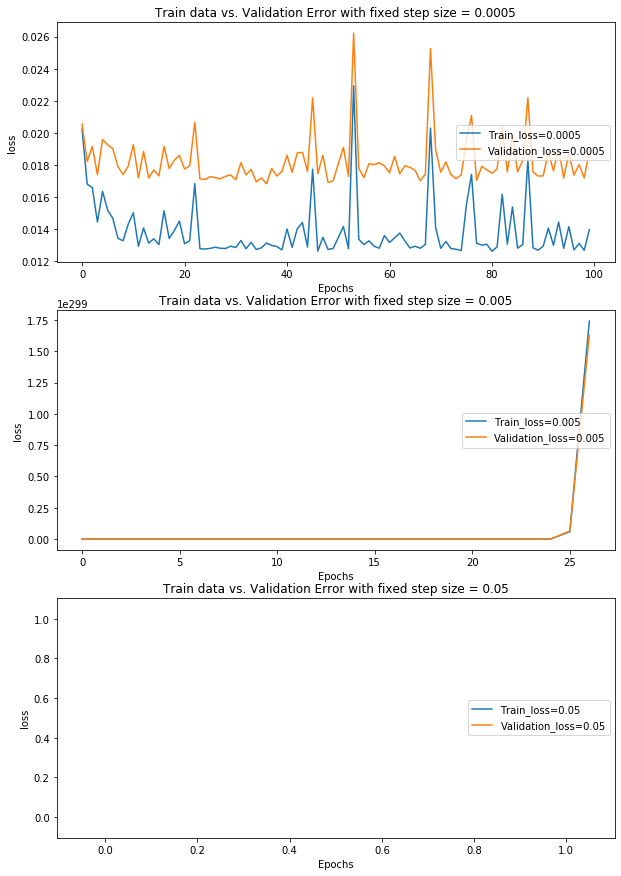

In [13]:
# graphs of validation and training error with epoch for different learning rates

axs={}
fig,(axs[0],axs[1],axs[2])=plt.subplots(3,1,figsize= (10,15))
n=0
for eta in learning_rates:
    axs[n].plot(np.array(np.arange(0,100)),train_loss[eta],label="Train_loss="+str(eta))

    axs[n].plot(np.array(np.arange(0,100)),val_loss[eta],label="Validation_loss="+str(eta))

    axs[n].set(xlabel= "Epochs", ylabel ="loss",
              title="Train data vs. Validation Error with fixed step size = "+str(eta))
    axs[n].legend(loc="right")
    n=n+1

In [15]:
Cs = [0.01,0.001]
C_keys=[str(c)+"/t" for c in Cs] + [str(c)+"/sqrt(t)" for c in Cs]
Cs = [0.01,0.001,0.01,0.001]

t =0 
for c in C_keys:
    print("Starting training SGD with eta = "+str(c))

    train_loss[c]=[]
    val_loss[c]=[]
    SGD_beta_hist[c] = stochastic_grad_descent(X_train_norm,y_train_norm, eta="C/t", C=Cs[t])

    for i in range(num_epoch):
        train_loss[c].append(squared_loss(X_train_norm,y_train_norm,SGD_beta_hist[c][i,-1]))
        val_loss[c].append(squared_loss(X_val_norm,y_val_norm,SGD_beta_hist[c][i,-1]))
    t+=1

Starting training SGD with eta = 0.01/t
Starting training SGD with eta = 0.001/t
Starting training SGD with eta = 0.01/sqrt(t)
Starting training SGD with eta = 0.001/sqrt(t)


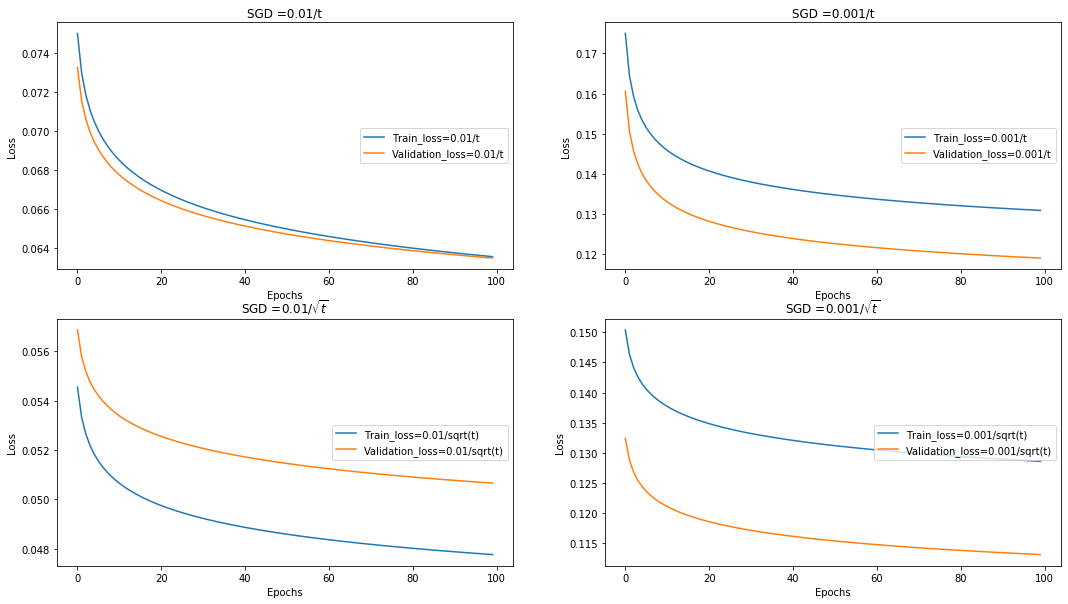

In [16]:
axs={}
fig,((axs[0],axs[1]),(axs[2],axs[3]))=plt.subplots(2,2,figsize=(18,10))
t=0

for c in C_keys:
    
    axs[t].plot(np.array(np.arange(0,100)),train_loss[c],label="Train_loss="+str(c))
    axs[t].plot(np.array(np.arange(0,100)),val_loss[c],label="Validation_loss="+str(c))
    
  
    axs[t].set(xlabel="Epochs", ylabel="Loss", title="SGD ={}/t".format(Cs[t]))
    if t>=2:
        axs[t].set(xlabel="Epochs", ylabel="Loss", title="SGD ={}/".format(Cs[t])+"$\sqrt{t}$")
    axs[t].legend(loc = "right")
    t+=1

### 4(e) 

In [17]:
# compare the test loss for SGD and 4(c)

min_loss= 100
min_step =""
min_ind =0 
beta_opt = np.zeros(X_train.shape[1])
all_steps = learning_rates  + C_keys 
for i in all_steps: 
    if min(val_loss[i])<min_loss:
        min_loss = min(val_loss[i])
        min_step = i 
        min_ind = np.where(val_loss[i]==min_loss)
        beta_opt = SGD_beta_hist[i][min_ind, -1].reshape(133)

In [18]:
y_test_centered=y_test - y_train_center
y_test_norm = y_test_centered /norm_y_train

X_test_centered = X_test - center_vec
X_test_norm = np.true_divide(X_test_centered, col_norms)

In [19]:
test_error_SGD = np.linalg.norm((y_test_norm - X_test_norm@beta_opt)*norm_y_train)/np.sqrt(len(y_test))
print("Error using SGD: "+str(test_error_SGD))

test_error_ols = np.linalg.norm((y_test_norm - X_test_norm@beta_ols)*norm_y_train)/np.sqrt(len(y_test))
print("Error using ols: "+str(test_error_ols))


Error using SGD: 1.0940211720789106
Error using ols: 1.0809369027614684
